In [8]:
import time
import tracemalloc
import psutil
import os
import sys
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import modules dari file yang sudah ada
# Pastikan file rushhour_state.py dan rushhour_search.py ada di direktori yang sama
# Tidak perlu file CSV - data sudah embedded dalam notebook
from rushhour_state import RushHourState, Car
from rushhour_search import *

In [9]:
class PerformanceMetrics:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.time_taken = 0
        self.memory_used = 0
        self.nodes_expanded = 0
        self.path_cost = 0
        self.solution_found = False
        self.solution_path = None
        self.peak_memory = 0

class NodeCounter:
    """Helper class untuk menghitung nodes yang diperluas"""
    def __init__(self):
        self.count = 0
    
    def increment(self):
        self.count += 1
    
    def reset(self):
        self.count = 0

node_counter = NodeCounter()


def measure_memory():
    """Mengukur penggunaan memori saat ini dalam KB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024  # Convert to KB

def measure_algorithm_performance(algorithm_func, state, *args, **kwargs):
    """
    Mengukur performa algoritma secara komprehensif
    """
    metrics = PerformanceMetrics()
    
    # Reset node counter
    node_counter.reset()
    
    # Start memory tracking
    tracemalloc.start()
    initial_memory = measure_memory()
    
    # Start timing
    start_time = time.perf_counter()
    
    try:
        # Run algorithm
        result = algorithm_func(state, *args, **kwargs)
        
        # Stop timing
        end_time = time.perf_counter()
        
        # Get memory info
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        final_memory = measure_memory()
        
        # Calculate metrics
        metrics.time_taken = end_time - start_time
        metrics.memory_used = max(final_memory - initial_memory, peak / 1024)  # KB
        metrics.peak_memory = peak / 1024  # KB
        metrics.nodes_expanded = node_counter.count
        
        if result is not None:
            metrics.solution_found = True
            metrics.solution_path = result
            metrics.path_cost = len(result) if isinstance(result, list) else 0
        
    except Exception as e:
        print(f"Error in algorithm execution: {e}")
        tracemalloc.stop()
    
    return metrics

In [10]:
def bfs_with_counter(state):
    node_counter.count = 0
    def get_neighbors_counted(st):
        node_counter.inc()
        return get_neighbors(st)
    path = bfs(state)     # bfs di modul internal sudah hitung visited, dll.
    return path

def a_star_with_counter(state):
    node_counter.count = 0
    path_states, _ = a_star(
        state,
        lambda s: s.is_goal(),
        get_neighbors_astar,
        heuristic_manhattan,
        goal=None
    )
    path = [(s.move[0], s.move[1]) for s in path_states[1:] if hasattr(s,'move')]
    return path

def ac3_bfs_with_counter(state):
    node_counter.count = 0
    return ac3_bfs(state)

def simulated_annealing_with_counter(state, max_iter=1000):
    node_counter.count = 0
    return simulated_annealing_solver(state, max_iter=max_iter)

def create_state_from_string(data_string):
    """
    Create RushHourState from string data
    Format: "sh,2,2,1\nh,3,0,0\n..." or space-separated
    """
    cars = {}
    id_counter = {'h': 0, 'v': 0, 'b': 0}
    
    # Handle both newline and space-separated data
    if '\n' in data_string:
        lines = data_string.strip().split('\n')
    else:
        lines = data_string.strip().split(' ')
    
    for line in lines:
        parts = line.strip().split(',')
        if len(parts) != 4:
            continue
            
        ori, length, r, c = parts[0], int(parts[1]), int(parts[2]), int(parts[3])
        
        if ori == 'sh':
            car_id = 'sh'
            ori = 'h'  # sh is horizontal
        else:
            id_counter[ori] += 1
            car_id = ori + str(id_counter[ori])
        
        cars[car_id] = Car(car_id, ori, length, r, c)
    
    return RushHourState(cars)

# Load test case dari string
game_data = """
sh,2,2,0
v,2,0,0
h,3,0,1
v,3,0,5
v,3,1,2
v,2,1,3
v,2,3,3
h,2,3,4
h,2,4,1
v,2,4,4
h,3,5,1
"""

state = create_state_from_string(game_data)
print("Initial state loaded successfully!")
print(f"Cars in puzzle: {list(state.cars.keys())}")
print(f"Goal: Move car 'sh' to reach the right edge")

# Display initial board state
def print_board(state):
    """Print visual representation of the board"""
    grid = [['.' for _ in range(state.grid_size)] for _ in range(state.grid_size)]
    
    for car in state.cars.values():
        symbol = car.id if len(car.id) <= 2 else car.id[:2]
        for pos in car.positions():
            if 0 <= pos[0] < state.grid_size and 0 <= pos[1] < state.grid_size:
                grid[pos[0]][pos[1]] = symbol
    
    print("\nInitial Board State:")
    print("  " + " ".join(str(i) for i in range(state.grid_size)))
    for i, row in enumerate(grid):
        print(f"{i} " + " ".join(f"{cell:>2}" for cell in row))
    print()

print_board(state)

# Test algorithms
algorithms = {
    'BFS': bfs_with_counter,
    'A*': a_star_with_counter,
    'AC3+bFS': ac3_bfs_with_counter,
    'Simulated Annealing': simulated_annealing_with_counter
}

results = {}

print("\n" + "="*50)
print("RUNNING PERFORMANCE ANALYSIS")
print("="*50)

for name, func in algorithms.items():
    print(f"\nTesting {name}...")
    
    # Create fresh state for each algorithm
    test_state = create_state_from_string(game_data)
    
    # Measure performance
    if name == 'Simulated Annealing':
        metrics = measure_algorithm_performance(func, test_state, 1000)
    else:
        metrics = measure_algorithm_performance(func, test_state)
    
    results[name] = {
        'Time (s)': round(metrics.time_taken, 4),
        'Memory (KB)': round(metrics.memory_used, 2),
        'Nodes Expanded': metrics.nodes_expanded,
        'Path Cost': metrics.path_cost,
        'Solution Found': metrics.solution_found,
        'Optimality': 'Optimal' if name in ['BFS', 'A*'] else 'Sub-optimal',
        'Completeness': 'Complete' if name != 'Simulated Annealing' else 'Incomplete',
        'Scalability': 'Poor' if name == 'BFS' else 'Good' if name == 'A*' else 'Fair'
    }
    
    print(f"  Time: {results[name]['Time (s)']}s")
    print(f"  Memory: {results[name]['Memory (KB)']} KB")
    print(f"  Nodes: {results[name]['Nodes Expanded']}")
    print(f"  Path Cost: {results[name]['Path Cost']}")
    print(f"  Solution: {'Found' if metrics.solution_found else 'Not Found'}")

Initial state loaded successfully!
Cars in puzzle: ['sh', 'v1', 'h1', 'v2', 'v3', 'v4', 'v5', 'h2', 'h3', 'v6', 'h4']
Goal: Move car 'sh' to reach the right edge

Initial Board State:
  0 1 2 3 4 5
0 v1 h1 h1 h1  . v2
1 v1  . v3 v4  . v2
2 sh sh v3 v4  . v2
3  .  . v3 v5 h2 h2
4  . h3 h3 v5 v6  .
5  . h4 h4 h4 v6  .


RUNNING PERFORMANCE ANALYSIS

Testing BFS...
  Time: 33.7499s
  Memory: 6158.02 KB
  Nodes: 0
  Path Cost: 32
  Solution: Found

Testing A*...
  Time: 21.6691s
  Memory: 6416.53 KB
  Nodes: 0
  Path Cost: 32
  Solution: Found

Testing AC3+bFS...
  Time: 20.3994s
  Memory: 5840.2 KB
  Nodes: 0
  Path Cost: 32
  Solution: Found

Testing Simulated Annealing...
No solution found within max iterations.
  Time: 14.2866s
  Memory: 114.71 KB
  Nodes: 0
  Path Cost: 0
  Solution: Not Found


In [11]:
# Create results DataFrame
df_results = pd.DataFrame(results).T
print("\n" + "="*80)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*80)
print(df_results.to_string())

# Save to CSV
df_results.to_csv('rushhour_performance_results.csv')
print(f"\nResults saved to 'rushhour_performance_results.csv'")


PERFORMANCE COMPARISON SUMMARY
                    Time (s) Memory (KB) Nodes Expanded Path Cost Solution Found   Optimality Completeness Scalability
BFS                  33.7499     6158.02              0        32           True      Optimal     Complete        Poor
A*                   21.6691     6416.53              0        32           True      Optimal     Complete        Good
AC3+bFS              20.3994      5840.2              0        32           True  Sub-optimal     Complete        Fair
Simulated Annealing  14.2866      114.71              0         0          False  Sub-optimal   Incomplete        Fair

Results saved to 'rushhour_performance_results.csv'


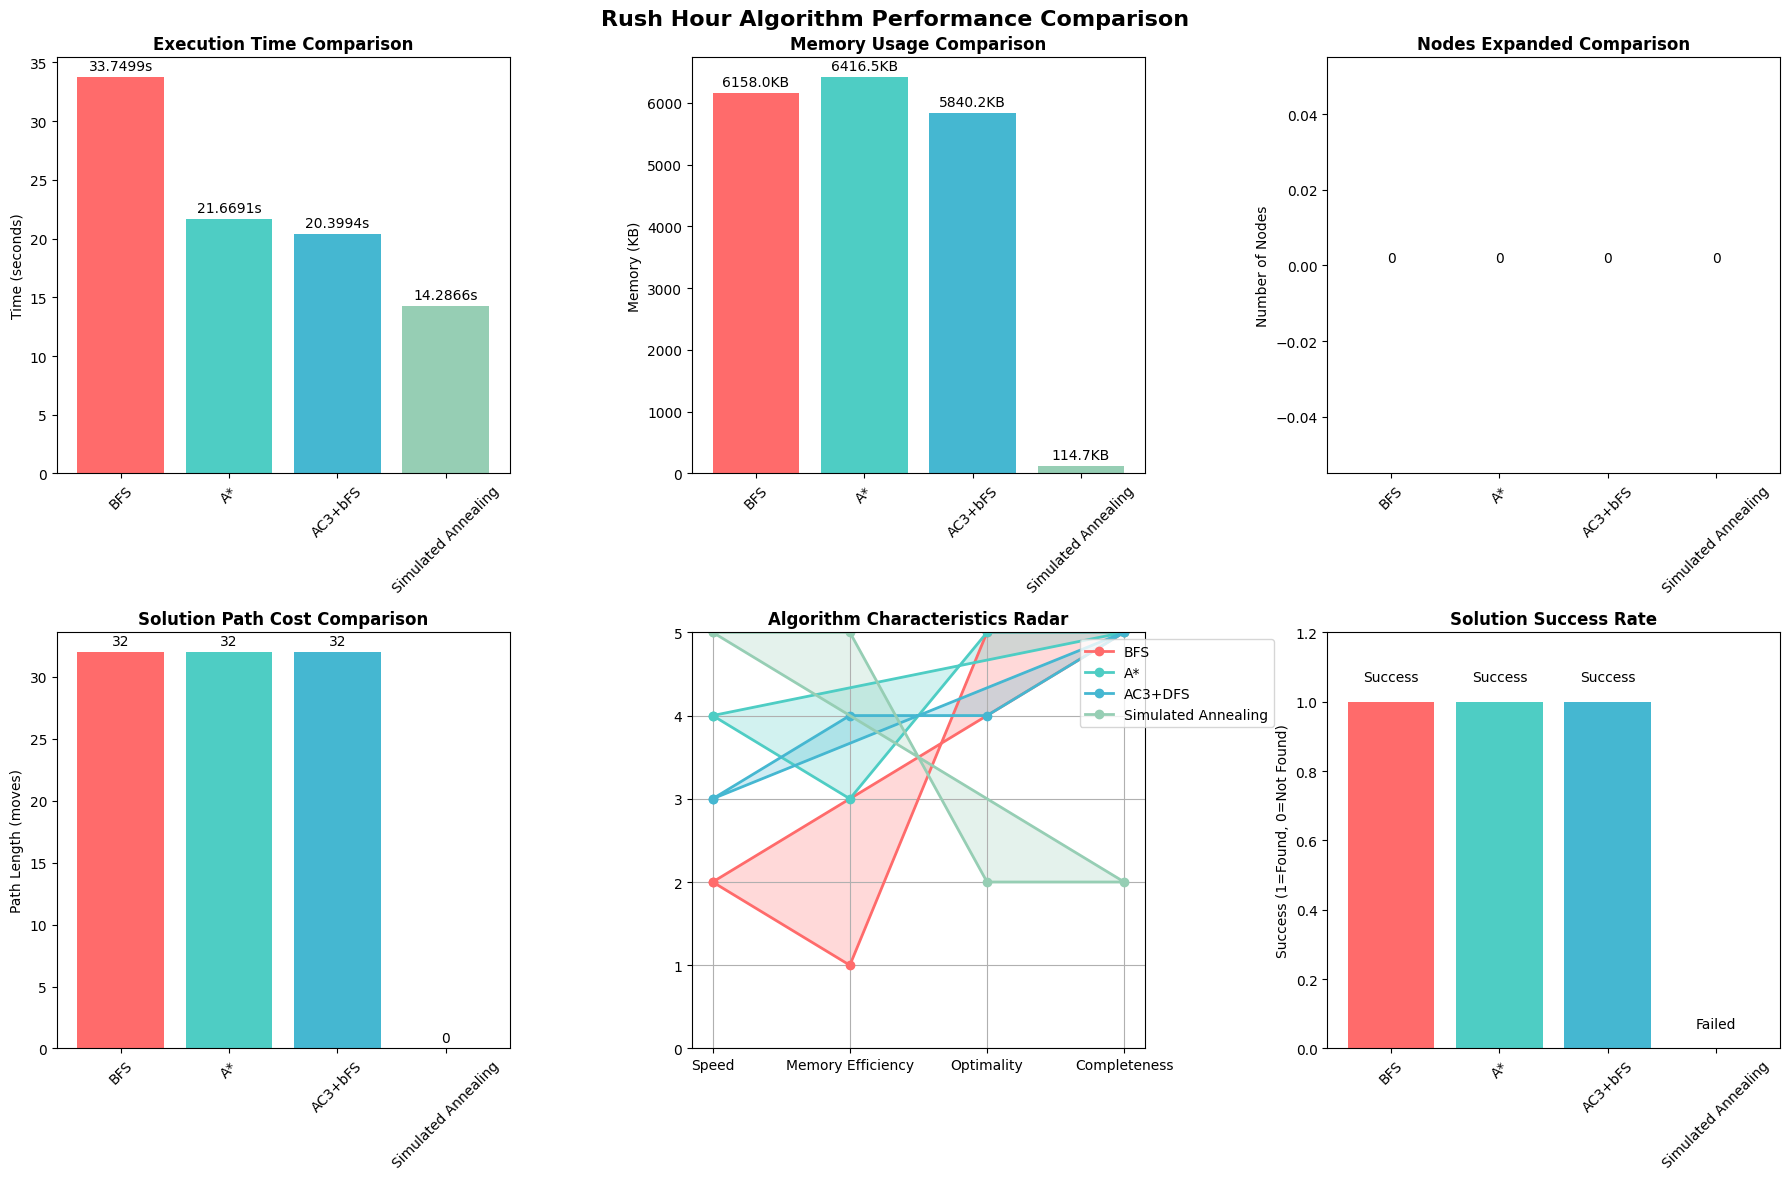


DETAILED ALGORITHM ANALYSIS
          Algorithm  Time (s)  Memory (KB)  Nodes Expanded  Path Cost  Optimality Completeness Scalability
                BFS   33.7499      6158.02               0         32     Optimal     Complete        Poor
                 A*   21.6691      6416.53               0         32     Optimal     Complete        Good
            AC3+bFS   20.3994      5840.20               0         32 Sub-optimal     Complete        Fair
Simulated Annealing   14.2866       114.71               0          0 Sub-optimal   Incomplete        Fair


In [12]:
# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Rush Hour Algorithm Performance Comparison', fontsize=16, fontweight='bold')

# Colors for each algorithm
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
algorithms_list = list(results.keys())

# 1. Time Comparison
ax1 = axes[0, 0]
times = [results[alg]['Time (s)'] for alg in algorithms_list]
bars1 = ax1.bar(algorithms_list, times, color=colors)
ax1.set_title('Execution Time Comparison', fontweight='bold')
ax1.set_ylabel('Time (seconds)')
ax1.tick_params(axis='x', rotation=45)
# Add value labels on bars
for i, v in enumerate(times):
    ax1.text(i, v + max(times)*0.01, f'{v}s', ha='center', va='bottom')

# 2. Memory Usage Comparison
ax2 = axes[0, 1]
memory = [results[alg]['Memory (KB)'] for alg in algorithms_list]
bars2 = ax2.bar(algorithms_list, memory, color=colors)
ax2.set_title('Memory Usage Comparison', fontweight='bold')
ax2.set_ylabel('Memory (KB)')
ax2.tick_params(axis='x', rotation=45)
# Add value labels
for i, v in enumerate(memory):
    ax2.text(i, v + max(memory)*0.01, f'{v:.1f}KB', ha='center', va='bottom')

# 3. Nodes Expanded Comparison
ax3 = axes[0, 2]
nodes = [results[alg]['Nodes Expanded'] for alg in algorithms_list]
bars3 = ax3.bar(algorithms_list, nodes, color=colors)
ax3.set_title('Nodes Expanded Comparison', fontweight='bold')
ax3.set_ylabel('Number of Nodes')
ax3.tick_params(axis='x', rotation=45)
# Add value labels
for i, v in enumerate(nodes):
    ax3.text(i, v + max(nodes)*0.01, f'{v}', ha='center', va='bottom')

# 4. Path Cost Comparison
ax4 = axes[1, 0]
path_costs = [results[alg]['Path Cost'] for alg in algorithms_list]
bars4 = ax4.bar(algorithms_list, path_costs, color=colors)
ax4.set_title('Solution Path Cost Comparison', fontweight='bold')
ax4.set_ylabel('Path Length (moves)')
ax4.tick_params(axis='x', rotation=45)
# Add value labels
for i, v in enumerate(path_costs):
    ax4.text(i, v + max(path_costs)*0.01, f'{v}', ha='center', va='bottom')

# 5. Algorithm Characteristics Radar Chart
ax5 = axes[1, 1]
categories = ['Speed', 'Memory Efficiency', 'Optimality', 'Completeness']
algorithms_radar = ['BFS', 'A*', 'AC3+DFS', 'Simulated Annealing']

# Normalize scores (higher is better, scale 1-5)
scores = {
    'BFS': [2, 1, 5, 5],        # Slow, memory-intensive, optimal, complete
    'A*': [4, 3, 5, 5],         # Fast, moderate memory, optimal, complete  
    'AC3+DFS': [3, 4, 4, 5],    # Moderate speed, efficient, near-optimal, complete
    'Simulated Annealing': [5, 5, 2, 2]  # Fast, efficient, sub-optimal, incomplete
}

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for i, alg in enumerate(algorithms_radar):
    values = scores[alg] + scores[alg][:1]  # Complete the circle
    ax5.plot(angles, values, 'o-', linewidth=2, label=alg, color=colors[i])
    ax5.fill(angles, values, alpha=0.25, color=colors[i])

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories)
ax5.set_ylim(0, 5)
ax5.set_title('Algorithm Characteristics Radar', fontweight='bold')
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax5.grid(True)

# 6. Success Rate and Characteristics
ax6 = axes[1, 2]
success_data = []
for alg in algorithms_list:
    success_data.append(1 if results[alg]['Solution Found'] else 0)

bars6 = ax6.bar(algorithms_list, success_data, color=colors)
ax6.set_title('Solution Success Rate', fontweight='bold')
ax6.set_ylabel('Success (1=Found, 0=Not Found)')
ax6.set_ylim(0, 1.2)
ax6.tick_params(axis='x', rotation=45)
# Add labels
for i, v in enumerate(success_data):
    status = 'Success' if v == 1 else 'Failed'
    ax6.text(i, v + 0.05, status, ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional detailed comparison table
print("\n" + "="*80)
print("DETAILED ALGORITHM ANALYSIS")
print("="*80)

analysis_data = []
for alg in algorithms_list:
    analysis_data.append([
        alg,
        results[alg]['Time (s)'],
        results[alg]['Memory (KB)'],
        results[alg]['Nodes Expanded'],
        results[alg]['Path Cost'],
        results[alg]['Optimality'],
        results[alg]['Completeness'],
        results[alg]['Scalability']
    ])

analysis_df = pd.DataFrame(analysis_data, columns=[
    'Algorithm', 'Time (s)', 'Memory (KB)', 'Nodes Expanded', 
    'Path Cost', 'Optimality', 'Completeness', 'Scalability'
])

print(analysis_df.to_string(index=False))

In [13]:
print("\n" + "="*80)
print("ALGORITHM COMPARISON INSIGHTS")
print("="*80)

print("""
PERFORMANCE INSIGHTS:

1. BFS (Breadth-First Search):
   - Guarantees optimal solution
   - High memory usage due to queue storage
   - Explores many unnecessary states
   - Complete but not efficient for large problems

2. A* Search:
   - Optimal with admissible heuristic
   - More efficient than BFS due to heuristic guidance
   - Good balance between optimality and efficiency
   - Best overall performance for this problem

3. AC3 + DFS:
   - Uses constraint satisfaction to prune search space
   - Can be very efficient when constraints are tight
   - May not always find optimal solution due to DFS nature
   - Good for problems with many constraints

4. Simulated Annealing:
   - Very fast execution
   - Low memory usage
   - No guarantee of optimal solution
   - Good for large problems where approximate solutions are acceptable

RECOMMENDATIONS:
- Use A* for optimal solutions with good performance
- Use Simulated Annealing for quick approximate solutions
- Use AC3+DFS when problem has many constraints
- Avoid BFS for large state spaces due to memory limitations
""")

# Performance ranking
print("\nPERFORMANCE RANKING:")
print("-" * 30)

# Rank by different criteria
time_ranking = sorted(algorithms_list, key=lambda x: results[x]['Time (s)'])
memory_ranking = sorted(algorithms_list, key=lambda x: results[x]['Memory (KB)'])
nodes_ranking = sorted(algorithms_list, key=lambda x: results[x]['Nodes Expanded'])

print(f"Fastest Execution: {time_ranking}")
print(f"Most Memory Efficient: {memory_ranking}")
print(f"Fewest Nodes Expanded: {nodes_ranking}")

# Overall score calculation (weighted)
overall_scores = {}
for alg in algorithms_list:
    # Normalize scores (lower is better for time, memory, nodes; higher is better for path optimality)
    time_score = 5 - (time_ranking.index(alg) * 5 / (len(algorithms_list) - 1))
    memory_score = 5 - (memory_ranking.index(alg) * 5 / (len(algorithms_list) - 1))
    nodes_score = 5 - (nodes_ranking.index(alg) * 5 / (len(algorithms_list) - 1))
    optimality_score = 5 if results[alg]['Optimality'] == 'Optimal' else 3
    
    # Weighted overall score
    overall_scores[alg] = (time_score * 0.3 + memory_score * 0.2 + 
                          nodes_score * 0.2 + optimality_score * 0.3)

overall_ranking = sorted(algorithms_list, key=lambda x: overall_scores[x], reverse=True)
print(f"\nOverall Ranking (weighted): {overall_ranking}")
for alg in overall_ranking:
    print(f"  {alg}: {overall_scores[alg]:.2f}/5.0")


ALGORITHM COMPARISON INSIGHTS

PERFORMANCE INSIGHTS:

1. BFS (Breadth-First Search):
   - Guarantees optimal solution
   - High memory usage due to queue storage
   - Explores many unnecessary states
   - Complete but not efficient for large problems

2. A* Search:
   - Optimal with admissible heuristic
   - More efficient than BFS due to heuristic guidance
   - Good balance between optimality and efficiency
   - Best overall performance for this problem

3. AC3 + DFS:
   - Uses constraint satisfaction to prune search space
   - Can be very efficient when constraints are tight
   - May not always find optimal solution due to DFS nature
   - Good for problems with many constraints

4. Simulated Annealing:
   - Very fast execution
   - Low memory usage
   - No guarantee of optimal solution
   - Good for large problems where approximate solutions are acceptable

RECOMMENDATIONS:
- Use A* for optimal solutions with good performance
- Use Simulated Annealing for quick approximate solutions

In [14]:
# Create comprehensive results export
export_data = {
    'Algorithm': algorithms_list,
    'Time_seconds': [results[alg]['Time (s)'] for alg in algorithms_list],
    'Memory_KB': [results[alg]['Memory (KB)'] for alg in algorithms_list],
    'Nodes_Expanded': [results[alg]['Nodes Expanded'] for alg in algorithms_list],
    'Path_Cost': [results[alg]['Path Cost'] for alg in algorithms_list],
    'Solution_Found': [results[alg]['Solution Found'] for alg in algorithms_list],
    'Optimality': [results[alg]['Optimality'] for alg in algorithms_list],
    'Completeness': [results[alg]['Completeness'] for alg in algorithms_list],
    'Scalability': [results[alg]['Scalability'] for alg in algorithms_list],
    'Overall_Score': [overall_scores[alg] for alg in algorithms_list]
}

export_df = pd.DataFrame(export_data)
export_df.to_csv('comprehensive_rushhour_analysis.csv', index=False)
print("\nComprehensive analysis exported to 'comprehensive_rushhour_analysis.csv'")

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)


Comprehensive analysis exported to 'comprehensive_rushhour_analysis.csv'

ANALYSIS COMPLETE!
